In [1]:
import numpy as np
import scipy
from astropy.io import fits
from astropy.table import Table
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.cosmology import Planck18 as cosmo
from functools import partial

In [63]:
path_halo = '/sps/lsst/groups/clusters/cluster_comparison_project/after_matching/cosmoDC2_pywazp.DC2.tpz.T500k.pointEstimateMags/zband/member_matching/fshare_0.1_pref_more_massive/cat1.fits'

path_amas = '/sps/lsst/groups/clusters/cluster_comparison_project/after_matching/cosmoDC2_pywazp.DC2.tpz.T500k.pointEstimateMags/zband/member_matching/fshare_0.1_pref_more_massive/cat2.fits'

t = Table.read(path_amas)

def table(path):
    with fits.open(path) as hdul:
        table = Table(hdul[1].data)
    return table

t_halo = table(path_halo)
t_amas = table(path_amas)
t_amas_match = t_amas[t_amas["mt_cross"] !='']

M = []
for id in t_amas_match["mt_cross"]:
    ligne = t_halo[t_halo["halo_id"] == id]
    M.append(ligne["m200c"][0])
t_amas_match["M"] = M
t_amas_match = t_amas_match[t_amas_match["snr"]>6]

def tableau_coupure_n200(coupure):
    return t_amas_match[t_amas_match["n200"]>coupure]

Mp, zp = 10**14.3, 0.5
list_coupures = np.linspace(20, 80, 13)
print("liste des coupures :", list_coupures)

# renvoie le ln de la probabilité d'observer nos données (tend vers 0 idéalement)
#X est le catalogue
def _ln_L(params, X):
    A, B, C, D, E, F = params
    #A, B, D = params
    C, E, F = 0, 0, 0  # on fixe 3 paramètr
    pop, M, z = np.log(X["n200"]), X["M"], X["zp"]
    mean_alpha = A + B*np.log(M/Mp) + C*np.log((1+z)/(1+zp))
    sigma = D + E*np.log(M/Mp) + F*np.log((1+z)/(1+zp))
    sigma = np.clip(sigma, 1e-5, None)
    #print("sigma max/min :", max(sigma), min(sigma))
    #log-Vraissemblance
    ln_L = - sum(np.log(sigma*(2*np.pi)**0.5)) - sum(0.5*((pop-mean_alpha)/sigma)**2)
    #print(-ln_L)
    return -ln_L

liste des coupures : [20. 25. 30. 35. 40. 45. 50. 55. 60. 65. 70. 75. 80.]


In [3]:
display(t)

id,ra,dec,zp,n200,n200_err,snr,mt_self,mt_other,mt_multi_self,mt_multi_other,mt_cross
bytes30,float64,float64,float32,float32,float32,float32,bytes13,bytes13,bytes41,bytes97,bytes13
193028,49.573452898865064,-44.19856875299083,0.91671336,6.376,0.523,3.002,--,--,--,--,--
98081,49.6256607949887,-44.13217144566751,0.48552513,13.859,2.681,4.106,--,--,--,--,--
79976,49.62747410750222,-44.24822082065141,0.6869996,14.41,2.593,4.422,--,--,--,--,--
125281,49.63162372606795,-44.29258668292809,0.6310984,5.504,0.963,3.718,--,--,--,--,--
28076,49.63867447643211,-44.13613370188215,0.2789399,11.002,1.894,6.104,122800185392,122800185392,122800185392,122800185392,122800185392
176286,49.64861908610109,-44.10978821648175,0.8442942,5.215,1.338,3.16,--,--,--,--,--
76639,49.652316087449314,-43.99831698753705,0.4461611,7.253,2.427,4.487,--,--,--,--,--
162375,49.663685012012536,-44.05312738361619,0.8984465,9.242,0.889,3.298,--,--,--,--,--
153302,49.672625936512404,-44.400156914868234,1.2347945,8.557,0.52,3.392,--,--,--,--,--


In [43]:
def parametres_incertitudes(coupure, P0 = [None]):
    if coupure == 0:
        X = t_amas_match
    else:
        X = tableau_coupure_n200(coupure)
    if P0[0] == None:
        p0 = np.random.uniform(1e-3, 0.2, 6)
    else:
        p0 = P0
    bounds = [
    (0, np.inf),  # A
    (0, np.inf),  # B
    (-2, 2),      # C
    (0, np.inf),  # D
    (-2, 2),      # E
    (-2, 2)       # F
    ]
    #bounds = [(0, np.inf), (0, np.inf), (1e-5, np.inf)]
    res = scipy.optimize.minimize(_ln_L, p0, args=(X,), method='L-BFGS-B', bounds = bounds)
    if not res.success:
        return [None]
    return res.x

In [44]:
# Objectif : déterminer l'incertitude sur mes paramètres libres avec une analyse de Montecarlo

In [75]:
list_A, list_B, list_C, list_D, list_E, list_F  = [], [], [], [], [], []

In [93]:
N = 1000
list_A0 = np.random.uniform(1e-3, 0.2, N)
list_B0 = np.random.uniform(1e-3, 0.2, N)
list_C0 = np.random.uniform(1e-3, 0.2, N)
list_D0 = np.random.uniform(1e-3, 0.2, N)
list_E0 = np.random.uniform(1e-3, 0.2, N)
list_F0 = np.random.uniform(1e-3, 0.2, N)
for i in range(N):
    if (100*i/N) % 5 == 0:
        print("progression : "+str(round(100*i/N, 2))+" %")
        #print("Nombre de valeurs :", len(list_A))
    #P0 = [list_A0[i], list_B0[i], list_C0[i], list_D0[i], list_E0[i], list_F0[i]]
    parametres = parametres_incertitudes(coupure = 50)
    if parametres[0] != None:
        list_A.append(parametres[0]) # récupération des paramètres
        list_B.append(parametres[1])
        list_C.append(parametres[2])
        list_D.append(parametres[3])
        list_E.append(parametres[4])
        list_F.append(parametres[5])

progression : 0.0 %
progression : 5.0 %
progression : 10.0 %
progression : 15.0 %
progression : 20.0 %
progression : 25.0 %
progression : 30.0 %
progression : 35.0 %
progression : 40.0 %
progression : 45.0 %
progression : 50.0 %
progression : 55.0 %
progression : 60.0 %
progression : 65.0 %
progression : 70.0 %
progression : 75.0 %
progression : 80.0 %
progression : 85.0 %
progression : 90.0 %
progression : 95.0 %


In [94]:
# filtrage des valeurs aberrantes
std_A = np.std(np.array(list_A))
std_B = np.std(np.array(list_B))
std_C = np.std(np.array(list_C))
std_D = np.std(np.array(list_D))
std_E = np.std(np.array(list_E))
std_F = np.std(np.array(list_F))

mean_A = np.median(np.array(list_A))
mean_B = np.median(np.array(list_B))
mean_C = np.median(np.array(list_C))
mean_D = np.median(np.array(list_D))
mean_E = np.median(np.array(list_E))
mean_F = np.median(np.array(list_F))

table_param = Table()
table_param["A"] = list_A
table_param["B"] = list_B
table_param["C"] = list_C
table_param["D"] = list_D
table_param["E"] = list_E
table_param["F"] = list_F

# Filtre des données bruitées (écartées de la moyenne à plus de 10 écarts types)
mask = (
    (abs(table_param["A"] - mean_A) / std_A < 5) &
    (abs(table_param["B"] - mean_B) / std_B < 5) &
    (abs(table_param["C"] - mean_C) / std_C < 5) &
    (abs(table_param["D"] - mean_D) / std_D < 5) &
    (abs(table_param["E"] - mean_E) / std_E < 5) &
    (abs(table_param["F"] - mean_F) / std_F < 5)
    )
table_param = table_param[mask]

# Recalcul de l'écart type une fois les données nettoyées
std_A = np.std(table_param["A"])
std_B = np.std(table_param["B"])
std_C = np.std(table_param["C"])
std_D = np.std(table_param["D"])
std_E = np.std(table_param["E"])
std_F = np.std(table_param["F"])

mask = (
    (abs(table_param["A"] - mean_A) / std_A < 5) &
    (abs(table_param["B"] - mean_B) / std_B < 5) &
    (abs(table_param["C"] - mean_C) / std_C < 5) &
    (abs(table_param["D"] - mean_D) / std_D < 5) &
    (abs(table_param["E"] - mean_E) / std_E < 5) &
    (abs(table_param["F"] - mean_F) / std_F < 5)
    )
table_param = table_param[mask]

mean_A = np.array(table_param["A"]).mean()
mean_B = np.array(table_param["B"]).mean()
mean_C = np.array(table_param["C"]).mean()
mean_D = np.array(table_param["D"]).mean()
mean_E = np.array(table_param["E"]).mean()
mean_F = np.array(table_param["F"]).mean()

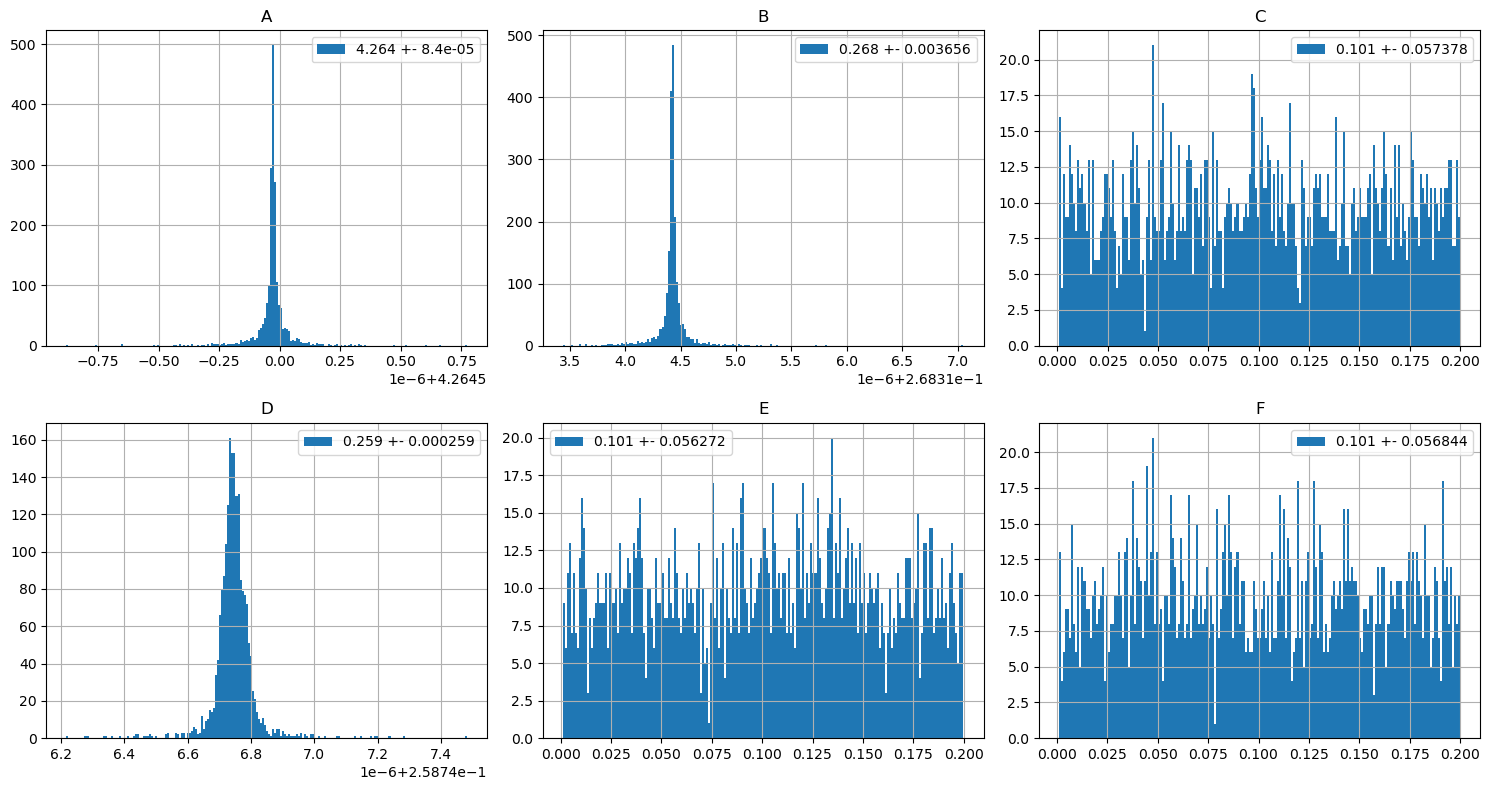

In [98]:
bins = max(len(list_E)//10, 20)
fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharex=False, sharey=False)

A = axes[0, 0]
A.hist(table_param["A"], bins = bins, label = str(round(mean_A, 3)) + " +- " + str(round(std_A, 6)))
A.set_title("A")
A.grid(True)
#A.set_xlim((mean_A-5*std_A, mean_A+5*std_A))
A.legend()
B = axes[0, 1]
B.hist(table_param["B"], bins = bins, label = str(round(mean_B, 3)) + " +- " + str(round(std_B, 6)))
B.set_title("B")
B.grid(True)
#B.set_xlim((mean_B-5*std_B, mean_B+5*std_B))
B.legend()
C = axes[0, 2]
C.hist(table_param["C"], bins = bins, label = str(round(mean_C, 3)) + " +- " + str(round(std_C, 6)))
C.set_title("C")
C.grid(True)
#C.set_xlim((mean_C-5*std_C, mean_C+5*std_C))
C.legend()

D = axes[1, 0]
D.hist(table_param["D"], bins = bins, label = str(round(mean_D, 3)) + " +- " + str(round(std_D, 6)))
D.set_title("D")
D.grid(True)
#D.set_xlim((mean_D-5*std_D, mean_D+5*std_D))
D.legend()
E = axes[1, 1]
E.hist(table_param["E"], bins = bins, label = str(round(mean_E, 3)) + " +- " + str(round(std_E, 6)))
E.set_title("E")
E.grid(True)
#E.set_xlim((mean_E-5*std_E, mean_E+5*std_E))
E.legend()
F = axes[1, 2]
F.hist(table_param["F"], bins = bins, label = str(round(mean_F, 3)) + " +- " + str(round(std_F, 6)))
F.set_title("F")
F.grid(True)
#F.set_xlim((mean_F-5*std_F, mean_F+5*std_F))
F.legend()

# Ajustement de l'espacement
fig.tight_layout()
plt.show()
plt.show()